In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import Model
#importlib.reload(Model)
import utils
import config


class ProgressiveTrainer:
    def __init__(self, config):
        self.default_path = config.default_path
        self.classes = config.classes
        self.dataset = config.dataset
        self.info = config.Info
        self.train_ratio = 0.5
        self.set_epoch = 50
        self.set_batch_size = 256
        self.model_name = "Training_from_scratch"

        self.trained_acc_all = []
        self.prev_acc_all = []
        self.init_acc_all = []
        self.X_test_prev_all = []
        self.y_test_prev_all = []

    def get_result(self, path, first_time, plot_learning_curve):
        feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=self.train_ratio)

        model = Model.Original_model_V1(X_train.shape[1:])
        init_acc = model.evaluate(X_test, y_test, verbose=0)[1]

        history, _ = Model.Train_model(
            model, X_train, y_train, X_test, y_test,
            self.set_epoch, self.set_batch_size, self.model_name,
            set_verbose=0, save_model_set=False
        )

        if plot_learning_curve:
            utils.visualize_history(history)

        test_acc = float(np.max(history.history['val_accuracy']))

        if first_time:
            self.X_test_prev_all = X_test
            self.y_test_prev_all = y_test
        else:
            self.X_test_prev_all = np.concatenate((self.X_test_prev_all, X_test), axis=0)
            self.y_test_prev_all = np.concatenate((self.y_test_prev_all, y_test), axis=0)

        prev_acc = model.evaluate(self.X_test_prev_all, self.y_test_prev_all, verbose=0)[1]

        return init_acc, test_acc, prev_acc

    def run(self, plot_learning_curve=False):
        for idx, session in enumerate(self.dataset):
            print(f"\n{'='*43}\nDataset {idx+1}/{len(self.dataset)} - Session {session}\n{'='*43}")
            path = os.path.join(self.default_path, session + 'raw/')
            first_time = (idx == 0)
            init_acc, test_acc, prev_acc = self.get_result(path, first_time, plot_learning_curve)

            self.init_acc_all.append(init_acc)
            self.trained_acc_all.append(test_acc)
            self.prev_acc_all.append(prev_acc)

        return self.init_acc_all, self.trained_acc_all, self.prev_acc_all


    def plot_results(self, baselines, baseline_K):

        plt.figure(figsize=(15, 8))
        plt.title('Training from scratch every time', fontsize=15)
        plt.plot(self.info, self.init_acc_all, marker='o', label='Untrained model on current data', linestyle='--')
        plt.plot(self.info, self.prev_acc_all, marker='o', label='Model trained + tested on accumulated data')
        plt.plot(self.info, self.trained_acc_all, marker='o', label='Model trained + tested on current split')

        for idx, base in enumerate(baselines):
            baseline_result = pd.read_csv(base)
            plt.plot(self.info, baseline_result['Accuracy'] / 100, marker='^', label=f'Baseline V{idx} - K:{baseline_K[idx]}', linestyle='--')

        plt.ylim([0, 1])
        plt.xlabel('Date (Sessions)')
        plt.ylabel('Test Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [2]:
prog_trainer = ProgressiveTrainer(config)
Init_acc_all, Prev_acc_all, Trained_acc_all = prog_trainer.run(plot_learning_curve=False)


Dataset 1/26 - Session Exp_2025-05-27/E8331D05289A/
Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 81.56%
Maximum validation accuracy : 86.83%

Dataset 2/26 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 84.78%
Maximum validation accuracy : 88.75%

Dataset 3/26 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 86.14%
Maximum validation accuracy : 92.52%

Dataset 4/26 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 85.18%
Maximum validation accuracy : 91.46%

Dataset 5/26 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Start Training (total epochs: 50)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 82.52%
Maximum validation accu

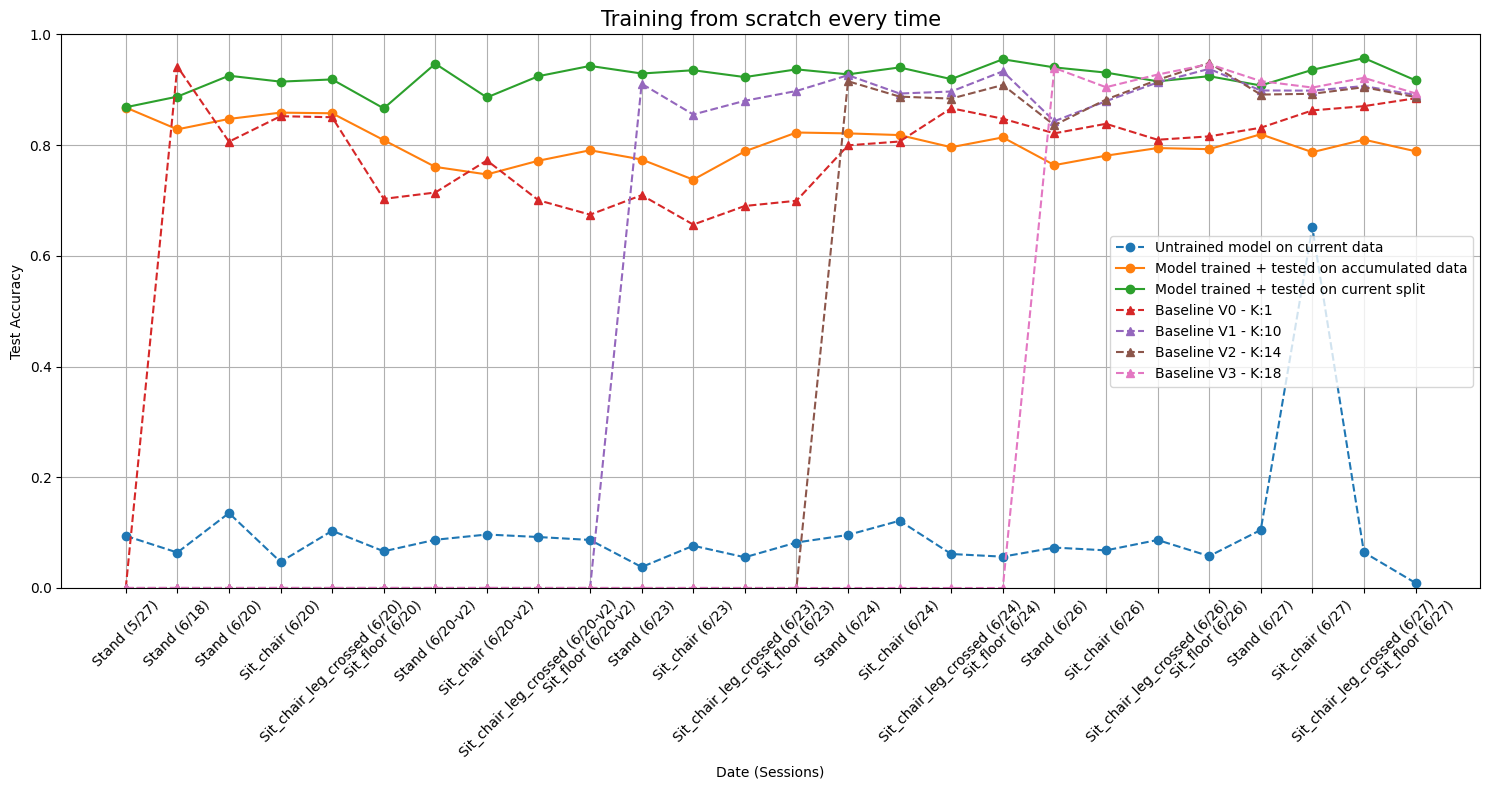

Average of acc without training anything (should be random): 9.90%
Average of acc using previous test data after training: 92.21%
Average of acc using current test data after training: 80.18%


In [3]:
#baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv'
baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_1data.csv'
baseline2_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_10data.csv'
baseline3_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_14data.csv'
baseline4_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_18data.csv'
baselines = [baseline1_csv_path, baseline2_csv_path,  baseline3_csv_path,  baseline4_csv_path]
baseline_K = ['1', '10', '14', '18']

prog_trainer.plot_results(baselines, baseline_K)

for idx, x in enumerate([Init_acc_all, Prev_acc_all, Trained_acc_all]):
    if idx==0:
        print(f"Average of acc without training anything (should be random): {np.mean(x)*100:.2f}%")
    elif idx==1:
        print(f"Average of acc using previous test data after training: {np.mean(x)*100:.2f}%")
    elif idx==2:
        print(f"Average of acc using current test data after training: {np.mean(x)*100:.2f}%")